In [2]:
import matplotlib.pyplot as plt
import pathlib,os,random
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, MaxPooling2D, Conv2D, Activation
import cv2
import pickle  
import numpy as np 
from sklearn.model_selection import train_test_split
import os 
from tqdm import tqdm

In [3]:
L=148
W=212

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def get_img(path):
  path = path.strip()
  img = cv2.imread(path)
  img  = cv2.resize(img, (L, W))
  return img

In [6]:
from os import listdir
from os.path import isfile, join
import numpy
mypath='/content/drive/MyDrive/AI Project/formated_muzzle_data/training/'
folders = [ f for f in listdir(mypath)]
filelocs=[]
for i in folders:
    x=mypath+i+"/"
    for j in listdir(x):
        filelocs.append(x+j)

In [7]:
images=[]
for name in tqdm(filelocs):
  images.append(get_img(name))
images=np.array(images,dtype=np.uint8)
images.shape

100%|██████████| 2947/2947 [16:55<00:00,  2.90it/s]


(2947, 212, 148, 3)

In [8]:
def plot_rgb_img(img):
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

In [9]:
def add_salt_pepper_noise(data, p=0.3):
  rows, columns, channels = data.shape
  output = np.zeros(data.shape, np.uint8)
  for i in range(rows):
    for j in range(columns):
      r = np.random.random()
      if r < p/2:
        output[i][j] = [0, 0, 0]
      elif r > p/2 and r <= p:
        output[i][j] = [255, 255, 255]
      else:
        output[i][j] = data[i][j]
  return output
def add_salt_pepper_to_dataset(data):
    count = 0
    end = len(data)
    output_data = []
    for count in tqdm(range(end)):
        output_data.append(add_salt_pepper_noise(data[count]))
    return np.array(output_data)

In [10]:
train_data, test_data = train_test_split(images, test_size=0.1, random_state=0, shuffle=True)

In [11]:
noisy_train_data = add_salt_pepper_to_dataset(train_data)
noisy_test_data = add_salt_pepper_to_dataset(test_data)
train_data = train_data / 255.0
test_data = test_data / 255.0
noisy_train_data = noisy_train_data / 255.0 
noisy_test_data = noisy_test_data / 255.0 

100%|██████████| 295/295 [00:13<00:00, 21.50it/s]


In [12]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [13]:
x = Input(shape=(W, L, 3)) 

# Encoder
e_conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
batchnorm_1 = BatchNormalization()(pool1)
e_conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(batchnorm_1)
pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
batchnorm_2 = BatchNormalization()(pool2)
e_conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(batchnorm_2)
pool3 = MaxPooling2D((2, 2), padding='same')(e_conv3)
batchnorm_3 = BatchNormalization()(pool3)
e_conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_3)
h = MaxPooling2D((2, 2), padding='same')(e_conv4)


# Decoder
d_conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(d_conv1)
d_conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(d_conv2)
d_conv3 = Conv2D(64, (3, 3), activation='relu')(up2)
up3 = UpSampling2D((2, 2))(d_conv3)
d_conv4 = Conv2D(32, (3, 3), activation='relu')(up3)
up4 = UpSampling2D((2, 2))(d_conv4)
r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up4)

model = Model(x, r)
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

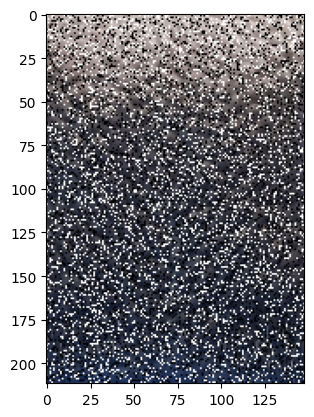

In [14]:
plt.imshow(noisy_train_data[0])

In [15]:
noisy_auto_encoder = model
noisy_auto_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 212, 148, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 212, 148, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 106, 74, 128)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 106, 74, 128)     512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 74, 128)      147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 37, 128)      0     

In [16]:
noisy_history = noisy_auto_encoder.fit(noisy_train_data, train_data, epochs=400, batch_size=32,validation_data=(noisy_test_data,test_data))

Epoch 1/400
83/83 [==============================] - 33s 197ms/step - loss: 0.0106 - accuracy: 0.6261 - val_loss: 0.0300 - val_accuracy: 0.6005
Epoch 2/400
83/83 [==============================] - 12s 141ms/step - loss: 0.0072 - accuracy: 0.7910 - val_loss: 0.0302 - val_accuracy: 0.6005
Epoch 3/400
83/83 [==============================] - 12s 141ms/step - loss: 0.0064 - accuracy: 0.8126 - val_loss: 0.0283 - val_accuracy: 0.6005
Epoch 4/400
83/83 [==============================] - 12s 139ms/step - loss: 0.0066 - accuracy: 0.8187 - val_loss: 0.0243 - val_accuracy: 0.6018
Epoch 5/400
83/83 [==============================] - 12s 142ms/step - loss: 0.0068 - accuracy: 0.8129 - val_loss: 0.0196 - val_accuracy: 0.7349
Epoch 6/400
83/83 [==============================] - 12s 143ms/step - loss: 0.0062 - accuracy: 0.8283 - val_loss: 0.0135 - val_accuracy: 0.7036
Epoch 7/400
83/83 [==============================] - 12s 143ms/step - loss: 0.0060 - accuracy: 0.8388 - val_loss: 0.0100 - val_accuracy:

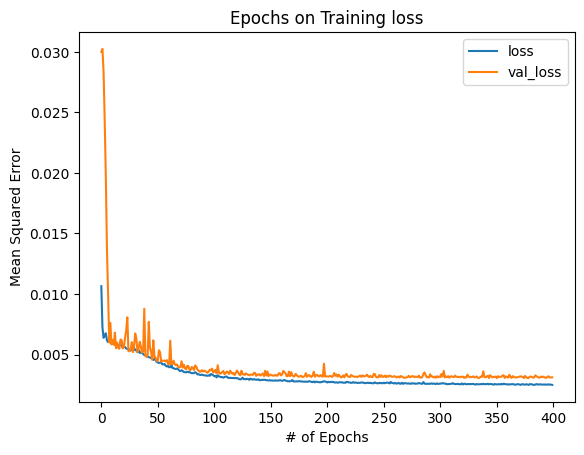

In [43]:
plt.plot(noisy_history.epoch, noisy_history.history['loss'], label = "loss")
plt.plot(noisy_history.epoch, noisy_history.history['val_loss'], label = "val_loss")
plt.title('Epochs on Training loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

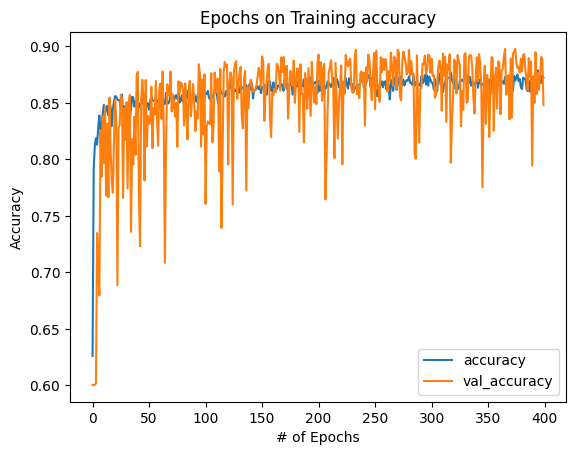

In [45]:
plt.plot(noisy_history.epoch, noisy_history.history['accuracy'], label="accuracy")
plt.plot(noisy_history.epoch, noisy_history.history['val_accuracy'], label="val_accuracy")
plt.title('Epochs on Training accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
result=noisy_auto_encoder.predict(noisy_train_data[0:5])

1/1 [==============================] - 1s 798ms/step


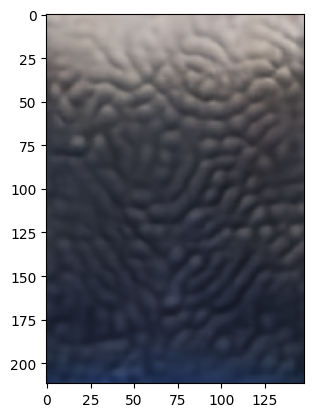

In [21]:
# plot_rgb_img(result[1])
plt.imshow(result[0])

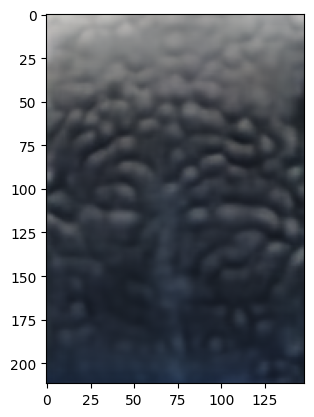

In [22]:
plt.imshow(result[1])

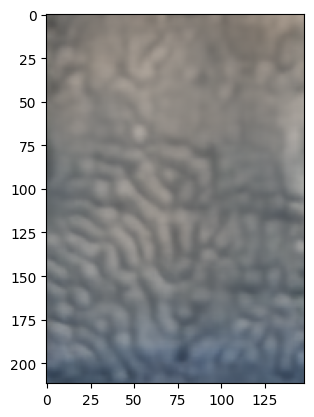

In [23]:
plt.imshow(result[2])

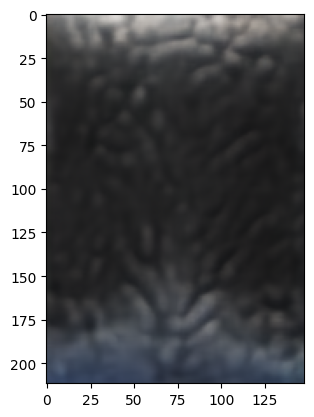

In [24]:
plt.imshow(result[3])

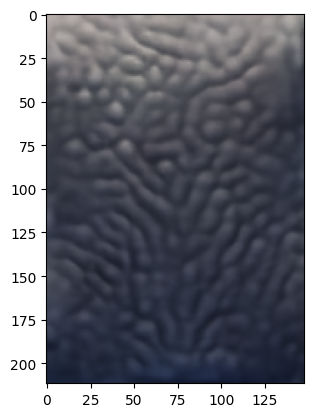

In [25]:
plt.imshow(result[4])

In [26]:
x=noisy_train_data[0:5]

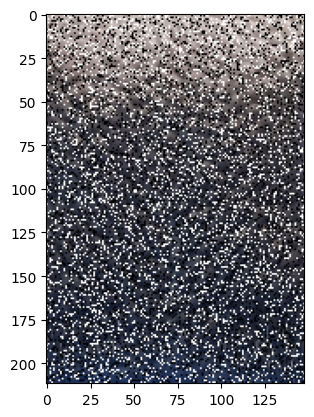

In [27]:
plt.imshow(x[0])

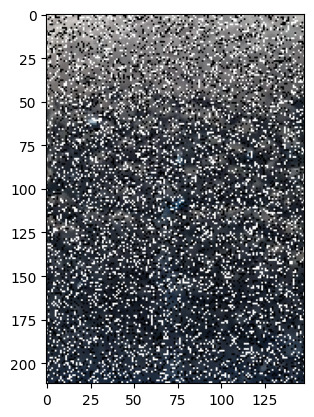

In [28]:
plt.imshow(x[1])

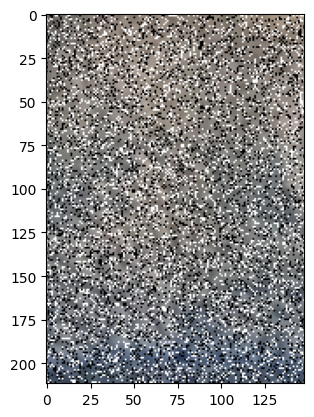

In [29]:
plt.imshow(x[2])

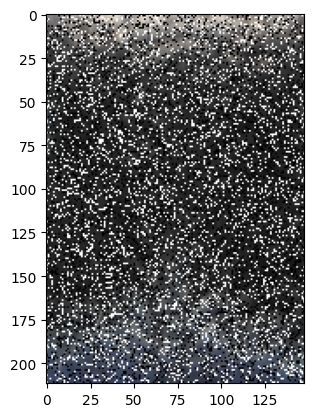

In [30]:
plt.imshow(x[3])

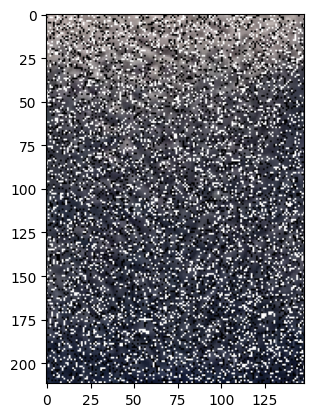

In [31]:
plt.imshow(x[4])

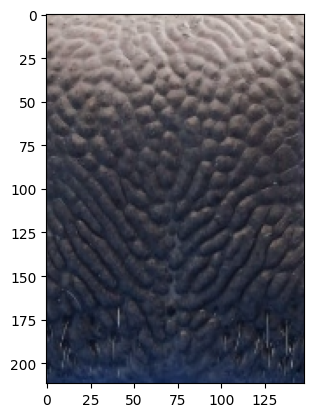

In [32]:
plt.imshow(train_data[0])

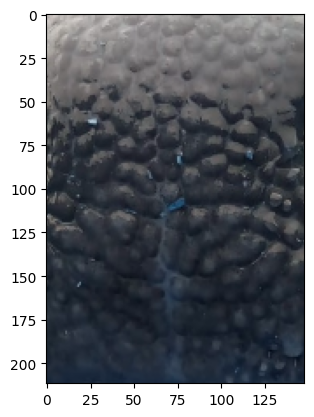

In [33]:
plt.imshow(train_data[1])

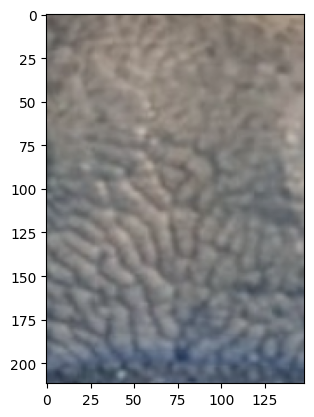

In [34]:
plt.imshow(train_data[2])

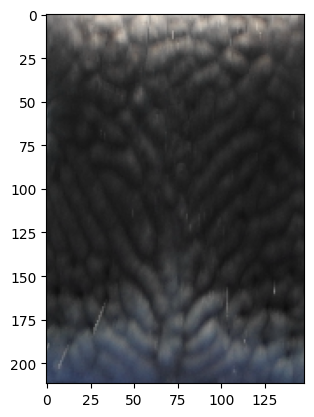

In [35]:
plt.imshow(train_data[3])

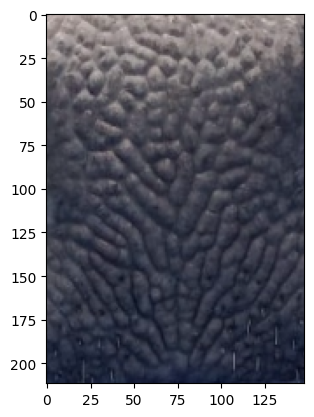

In [36]:
plt.imshow(train_data[4])

In [37]:
predictions = noisy_auto_encoder.predict(noisy_test_data)

10/10 [==============================] - 0s 44ms/step


In [38]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [39]:
from math import log10, sqrt

psnr = [PSNR(test_data[i], noisy_auto_encoder.predict(np.array([noisy_test_data[i]]))) for i in range(len(test_data))]

1/1 [==============================] - 0s 18ms/step


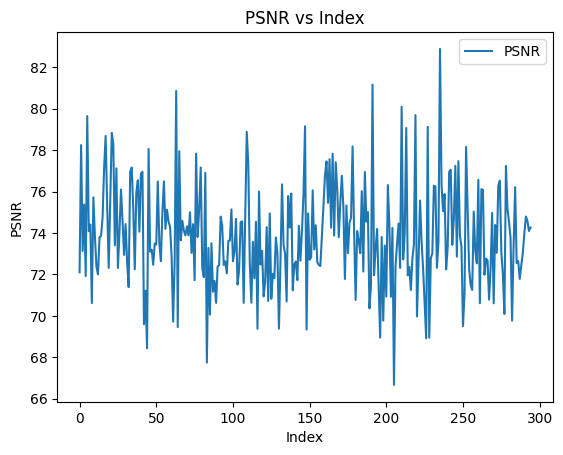

In [40]:
# Plot PSNR vs Index
plt.plot(psnr, label='PSNR')
plt.title('PSNR vs Index')
plt.xlabel('Index')
plt.ylabel('PSNR')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


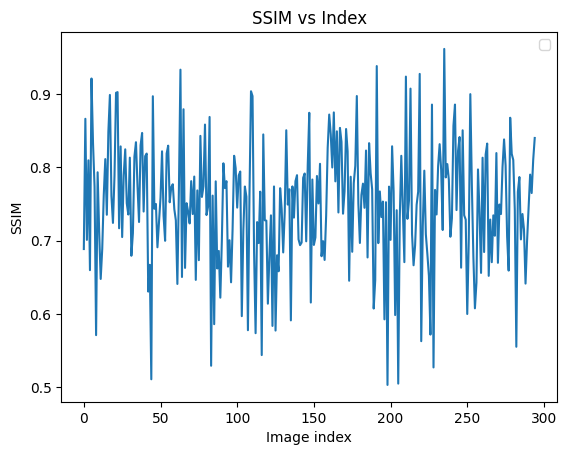

In [41]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

ssim_values = []

for i in range(len(noisy_test_data)):
    s = ssim(test_data[i], predictions[i], channel_axis=2)
    ssim_values.append(s)

plt.plot(ssim_values)
plt.title('SSIM vs Index')
plt.xlabel('Image index')
plt.ylabel('SSIM')
plt.legend()
plt.show()
